In [3]:
!python -m graph_notebook.ipython_profile.configure_ipython_profile

In [82]:
%graph_notebook_host growsmart-neptune.cluster-custom-cgogeml0cuty.eu-west-3.neptune.amazonaws.com

set host to growsmart-neptune.cluster-custom-cgogeml0cuty.eu-west-3.neptune.amazonaws.com


In [83]:
!pip install ipywidgets
!pip install folium
!pip install pillow
!pip install plotly
!pip install dash
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import folium
import matplotlib.font_manager as fm
import plotly.graph_objects as go
import datetime

## Test of the queries

In [85]:
%%oc

MATCH (m)-[n:DESCRIBED_BY]->(s)
RETURN m, n, s limit 100

In [87]:
%%oc

MATCH (m)-[n:DESCRIBED_BY]->(s)
RETURN m, n, s limit 100

In [88]:
%%oc 

MATCH (n:Plant)-[PLANT_TYPE]->(m:Species)
RETURN m.`~id` AS plant, count(n) AS number
ORDER BY number DESC
limit 3

In [89]:
%%oc
MATCH(n)-[c]->(s)-[c2]->(d)
RETURN n, c, s, c2, d
LIMIT 100

In [90]:
%%oc

MATCH (m:Garden)
RETURN m LIMIT 2

In [91]:
%%oc

MATCH (m:Sensor)
RETURN m LIMIT 2

In [92]:
%%oc

MATCH (m:Plant)
RETURN m LIMIT 2

In [93]:
%%oc
MATCH (n:Garden)
RETURN n

In [94]:
%%oc
MATCH (n:Plant)-[PLANT_TYPE]->(m:Species)
RETURN n,m


## Diagrams for dashboards

#### Number of gardens per city

In [95]:
%%oc --store-to gardenCity
MATCH (n:Garden)-[c:LOCATED_IN]->(m:Location)
WHERE m.weather_city IN ['Barcelona', 'Tarragona', 'Madrid', 'Lleida', 'Girona']
RETURN m.weather_city AS city, count(n) AS garden_number

In [96]:
gardenCity_df = pd.json_normalize(gardenCity['results'])
gardenCity_df

,city,garden_number
0,Barcelona,1
1,Madrid,1
2,Lleida,1
3,Girona,2


In [98]:
import folium

madrid_coords = (40.4168, -3.7038)
girona_coords = (41.9793, 2.8214)
center_coords = ((madrid_coords[0] + girona_coords[0]) / 2, (madrid_coords[1] + girona_coords[1]) / 2)

map_garden = folium.Map(location=center_coords, zoom_start=8)

for index, row in gardenCity_df.iterrows():
    city = row['city']
    garden_number = row['garden_number']
    
    if city == 'Barcelona':
        latitude, longitude = 41.3851, 2.1734
    elif city == 'Tarragona':
        latitude, longitude = 41.1189, 1.2445
    elif city == 'Madrid':
        latitude, longitude = 40.4168, -3.7038
    elif city == 'Lleida':
        latitude, longitude = 41.6177, 0.6200
    elif city == 'Girona':
        latitude, longitude = 41.9793, 2.8214
    
    tooltip = f"City: {city}<br>Number of Gardens: {garden_number}"
    
    folium.Marker(
        location=[latitude, longitude],
        popup=city,
        tooltip=tooltip,
        icon=folium.Icon(color='green', icon='leaf')
    ).add_to(map_garden)
    
    folium.Marker(
        location=[latitude, longitude],
        icon=folium.DivIcon(
            icon_size=(150, 36),
            icon_anchor=(75, 55),  # Adjust the icon_anchor to move the sign upward
            html=f'<div style="font-size: 10pt; color: black;">Number of Gardens: {garden_number}</div>'
        )
    ).add_to(map_garden)

# Display the map
map_garden


#### Top 3 Species

In [101]:
%%oc --store-to topPlants

MATCH (n:Plant)-[PLANT_TYPE]->(m:Species)
RETURN m.plants_plant_name AS Specie, count(n) AS number
ORDER BY number DESC
limit 3


In [103]:
topPlants_df = pd.json_normalize(topPlants['results'])
topPlants_df

,Specie,number
0,Carrot,6
1,Oregano,6
2,Parsley,6


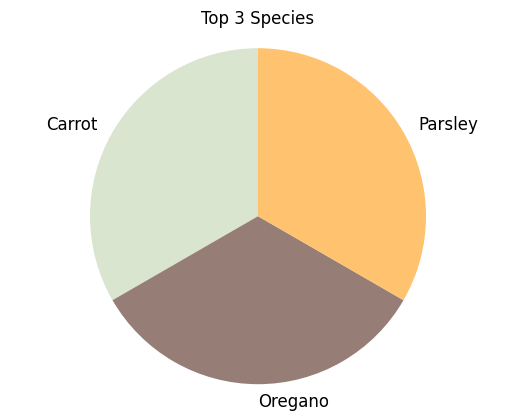

In [102]:
colors = ['#DAE5D0', '#967E76', '#FFC26F']

fig1, ax1 = plt.subplots()
ax1.pie(topPlants_df['number'], labels=topPlants_df['plant'], colors=colors,
        startangle=90, textprops={'fontsize': 12})
ax1.axis('equal')
ax1.set_title('Top 3 Species')

plt.show()


#### Least popular 3 plants

In [110]:
%%oc --store-to leastPopular

MATCH (n:Plant)-[PLANT_TYPE]->(m:Species)
RETURN m.plants_plant_name AS plant, count(n) AS number
ORDER BY number ASC
limit 3

In [111]:
leastPopular_df = pd.json_normalize(leastPopular['results'])
leastPopular_df

,plant,number
0,Peas,1
1,Cucumber,1
2,Tomatoes,1


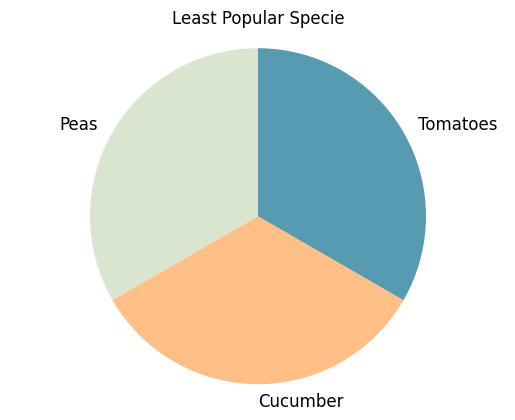

In [115]:
colors = ['#DAE5D0', '#FFBF86', '#579BB1']

fig2, ax2 = plt.subplots()
ax2.pie(leastPopular_df['number'], labels=leastPopular_df['plant'], colors=colors,
        startangle=90, textprops={'fontsize': 12})
ax2.axis('equal')
ax2.set_title('Least Popular Specie')

plt.show()

#### Number of sensors per garden

In [116]:
%%oc --store-to sensorCount
MATCH (n:Garden)-[c:HAS_SENSOR]->(m:Sensor)
RETURN n, count(m) AS sensorCount

In [117]:
sensorCount_df = pd.json_normalize(sensorCount['results'])
sensorCount_df

,sensorCount,n.~id,n.~entityType,n.~labels,n.~properties.iot_garden_name,n.~properties.iot_garden_id
0,1,GARDEN_B5A7D2,node,[Garden],Small Garden With Lamp,B5A7D2
1,1,GARDEN_16FFB3,node,[Garden],Middle Size Garden,16FFB3
2,1,GARDEN_91DE92,node,[Garden],Big Size Garden,91DE92
3,1,GARDEN_4D2E71,node,[Garden],Big Size Garden,4D2E71
4,1,GARDEN_75DF16,node,[Garden],Big Size Garden,75DF16


In [118]:
def plot_bar_graph(garden_id):
    # Filter the DataFrame based on the selected garden_id
    filtered_df = sensorCount_df[sensorCount_df['n.~id'] == garden_id]
    
    # Get the sensorCount for the selected garden_id
    sensor_count = filtered_df['sensorCount'].values[0]
    
    # Create the bar graph
    plt.figure(figsize=(8, 6))
    plt.bar(filtered_df.index, filtered_df['sensorCount'])
    plt.xlabel('Index')
    plt.ylabel('sensorCount')
    plt.title(f"sensorCount for Garden {garden_id}")
    plt.xticks(filtered_df.index)
    plt.yticks(range(sensor_count + 1))
    plt.show()

# Get unique garden IDs from the DataFrame
garden_ids = sensorCount_df['n.~id'].unique()

# Create a dropdown widget to select the garden ID
dropdown = widgets.Dropdown(options=garden_ids, description='Garden ID:')
output = widgets.Output()

def dropdown_event_handler(change):
    with output:
        output.clear_output()
        plot_bar_graph(change.new)

dropdown.observe(dropdown_event_handler, names='value')

# Display the dropdown widget and the output area
display(dropdown)
display(output)

Dropdown(description='Garden ID:', options=('GARDEN_B5A7D2', 'GARDEN_16FFB3', 'GARDEN_91DE92', 'GARDEN_4D2E71'…

Output()

#### Number of garden per type

In [119]:
%%oc --store-to gardenTypeCount
MATCH (n:Garden)
RETURN n.iot_garden_name as Garden_type, count(n) AS number

In [120]:
gardenTypeCount_df = pd.json_normalize(gardenTypeCount['results'])
gardenTypeCount_df

,Garden_type,number
0,Big Size Garden,3
1,Middle Size Garden,1
2,Small Garden With Lamp,1


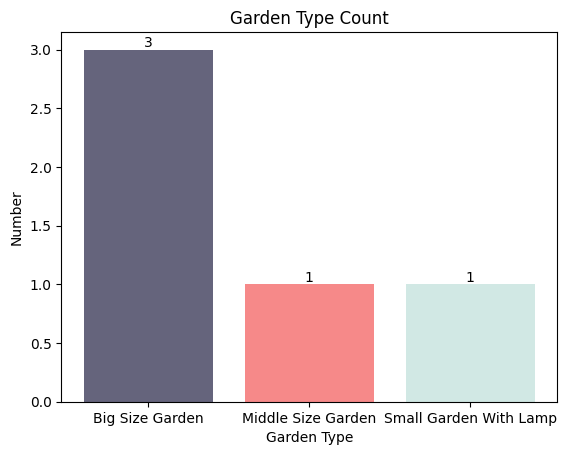

In [134]:
# Convert 'number' column to numeric
gardenTypeCount_df['number'] = pd.to_numeric(gardenTypeCount_df['number'])

# Filter out rows where 'Garden_type' is 'None'
filtered_df = gardenTypeCount_df[gardenTypeCount_df['Garden_type'] != 'None']

# Aggregate the data by garden type
aggregated_df = filtered_df.groupby('Garden_type')['number'].sum().reset_index()

# Define a custom pastel color palette
pastel_colors = ['#65647C', '#F68989', '#D1E8E4']

# Create the bar chart for Garden Type Count with custom pastel colors
fig3, ax3 = plt.subplots()
ax3.bar(aggregated_df['Garden_type'].astype(str), aggregated_df['number'], color=pastel_colors)
ax3.set_xlabel('Garden Type')
ax3.set_ylabel('Number')
ax3.set_title('Garden Type Count')
ax3.tick_params(axis='x', rotation=360)

# Add labels for the count of plants
for i, number in enumerate(aggregated_df['number']):
    ax3.text(i, number, str(number), ha='center', va='bottom')

plt.show()


#### ML model results visualisation

In [123]:
ML_df = pd.read_csv('sample-results.csv')

In [124]:
ML_df.head(5)

,plant_id,sensor_id,sdid,plant_status,event_id,value,value_label_iot_co,value_label_iot_humidity,value_label_iot_lpg,value_label_iot_rainfall,value_label_iot_smoke,value_label_iot_soil_humidity,value_label_iot_soil_nitrogen,value_label_iot_soil_ph,value_label_iot_soil_phosporous,value_label_iot_soil_potassium,value_label_iot_soil_temp,value_label_iot_temp,predicted_status
0,PLANT_6328e6bf-cb0b-4c74-87c3-fd2bcdb07251,SENSOR_18:24:as:kf:24:00,SENSORDATA_58e5cf72-ee27-5cad-b4f2-230f4f761cf3,1.0,EVENT_901666b0-8de7-5fb1-9654-12ff070a6ced,0.714286,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,PLANT_e237c159-b17d-40ee-b584-03259b0478b7,SENSOR_kd:sd:3a:33:69:42,SENSORDATA_7117282c-337c-5109-829e-a2d9adac4825,0.0,EVENT_1db9690c-4734-51ee-9fb7-15510def9bfb,0.468399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,PLANT_1b5a55fc-517e-4878-9ab9-533a3939caf2,SENSOR_kd:sd:3a:33:69:42,SENSORDATA_bb6e222a-9cc0-5d80-8373-181745c5c010,0.0,EVENT_f75a3060-415d-58c3-97af-499a29d2bcf4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,PLANT_b874295f-5878-497c-99ff-789be0da6bde,SENSOR_o0:4e:ve:rt:1l:l1,SENSORDATA_5f3bb94f-37b3-5f1c-bc99-8ad4a9a317df,1.0,EVENT_db5f197c-0800-52fb-b206-9d42c80323a1,0.957772,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,PLANT_1508f8b3-72d0-45fb-a3fa-c1ce84d27810,SENSOR_kd:sd:3a:33:69:42,SENSORDATA_dc058ba9-5284-52e4-a0f3-34a3750a4073,0.0,EVENT_1db9690c-4734-51ee-9fb7-15510def9bfb,0.400000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


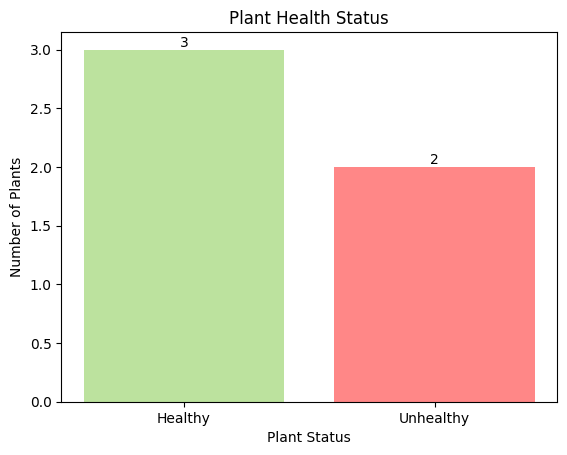

In [136]:
# Count the number of healthy and unhealthy plants
healthy_count = df[df['predicted_status'] == 1.0].shape[0]
unhealthy_count = df[df['predicted_status'] == 0.0].shape[0]

# Create a bar chart to visualize the counts
categories = ['Healthy', 'Unhealthy']
counts = [healthy_count, unhealthy_count]

# Define the colors for the bars
bar_colors = ['#BCE29E', '#FF8787']

fig4, ax4 = plt.subplots()
ax4.bar(categories, counts, color=bar_colors)
ax4.set_xlabel('Plant Status')
ax4.set_ylabel('Number of Plants')
ax4.set_title('Plant Health Status')

# Add labels for the count of plants
for i, count in enumerate(counts):
    ax4.text(i, count, str(count), ha='center', va='bottom')

# Return the figure object for inclusion in a Jupyter dashboard
plt.show()

## Dashboard

In [152]:

# Define the desired height for the map widget
map_height = '300px'

# Create widget instances for each visualization
fig1_widget = widgets.Output()
fig2_widget = widgets.Output()
fig3_widget = widgets.Output()
fig4_widget = widgets.Output()

# Render each visualization in its respective widget
with fig1_widget:
    display(fig1)
with fig2_widget:
    display(fig2)
with fig3_widget:
    display(fig3)
with fig4_widget:
    display(fig4)

# Set the layout height for the map widget
map_widget.layout.height = map_height

# Create a vertical layout for the figures in the second row
row2_layout = widgets.HBox([fig1_widget, fig3_widget, fig2_widget])

# Create a vertical layout for the first row with fig4 and map_widget
first_row_layout = widgets.HBox([fig4_widget, map_widget])

# Create a vertical layout for the entire dashboard with the first row and second row
dashboard_layout = widgets.VBox([first_row_layout, row2_layout])

# Create a border layout for the dashboard
dashboard_border = widgets.Box(
    [dashboard_layout],
    layout=widgets.Layout(
        border='2px solid #AAAAAA',
        padding='10px',
        margin='10px',
        background_color='white',  # Set background color of the border
    )
)

# Create a header with the name and current date
current_date = datetime.datetime.now().strftime("%d %b. %Y")
header_text = widgets.HTML(f"<h2 style='text-align: center; margin: 0 auto;'>GrowSmart {current_date}</h2>")
header_box = widgets.Box(
    [header_text],
    layout=widgets.Layout(
        background_color='#F0F0F0',
        padding='10px',
        margin='10px',
    )
)

# Create a vertical layout for the dashboard with the header and border
dashboard = widgets.VBox([header_box, dashboard_border])

# Display the dashboard
display(dashboard)